In [1]:
# great example here: 
# https://idiotdeveloper.com/dcgan-implementing-deep-convolutional-generative-adversarial-network-in-tensorflow/
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import os
from glob import glob
from matplotlib import pyplot
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

In [2]:
# hyperparameters
IMG_H = 64
IMG_W = 64
IMG_C = 3
batch_size = 128
latent_dim = 128
num_epochs = 60
# images_path = glob("data/*")
images_path = glob('../../input/reconnaissance/*')

In [3]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [4]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    # resize image
    img = img[:, :, :3]
    return img

In [5]:
def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [6]:
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
        )(inputs)

    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    return x

In [7]:
def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)

    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
    return x

In [8]:
def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    noise = Input(shape=(latent_dim,), name="generator_noise_input")

    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)

    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )

    x = conv_block(x,
        num_filters=3,
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = Activation("tanh")(x)

    return Model(noise, fake_output, name="generator")

In [9]:
def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(image_input, x, name="discriminator")

In [10]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

In [11]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = f"../models/samples/generated_plot_epoch-{epoch+1}.png"
    pyplot.savefig(filename)
    pyplot.close()

In [12]:
def generate_test_image(model, noise_dim=latent_dim):
    test_input = tf.random.normal([1, noise_dim])
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))
    plt.imshow((predictions[0, :, :, :] * 127.5 + 127.5) / 255.)
    plt.axis('off') 
    plt.show()

In [13]:
def generate_and_show_images(generator, noise_dim=latent_dim, rows=4, cols=4):
    predictions = generator(tf.random.normal([16, noise_dim]))
    print(predictions.shape)
    fig = plt.figure(figsize=(9,9))
    for i in range(predictions.shape[0]):
        plt.subplot(rows, cols, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
        plt.axis('off') 
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [14]:
d_model = build_discriminator()
g_model = build_generator(latent_dim)

if os.path.exists('../models/saved_model/d_model.h5') and os.path.exists('../models/saved_model/g_model.h5'):
    d_model.load_weights("../models/saved_model/d_model.h5")
    g_model.load_weights("../models/saved_model/g_model.h5")
else:
    gan = GAN(d_model, g_model, latent_dim)
    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)
    images_dataset = tf_dataset(images_path, batch_size)

    for epoch in tqdm(range(num_epochs)):
        gan.fit(images_dataset, epochs=1)
        g_model.save("../models/saved_model/g_model.h5")
        d_model.save("../models/saved_model/d_model.h5")

        n_samples = 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))

d_model.summary()
g_model.summary()

  0%|          | 0/60 [00:00<?, ?it/s]

4/4 [==============================] - 18s 4s/step - d1_loss: 0.2040 - d2_loss: 0.2811 - g_loss: 2.3172
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_______________

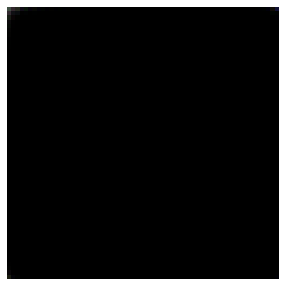

In [17]:
generate_test_image(g_model)

(16, 64, 64, 3)


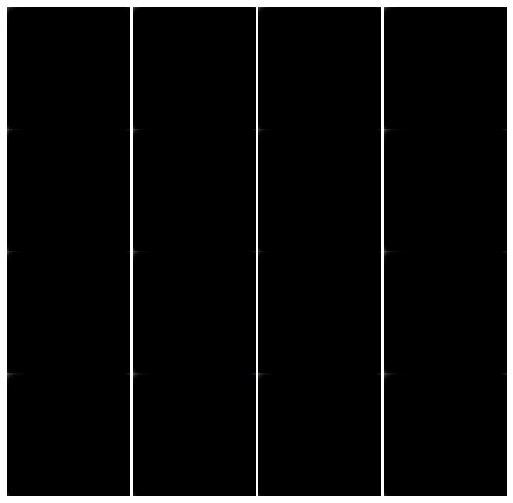

In [18]:
generate_and_show_images(g_model)